In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib as mpl
import mplhep as hep
hep.style.use("CMS")

plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'
import ROOT


plt.rcParams["figure.figsize"] = (10, 8)


Welcome to JupyROOT 6.27/01


In [78]:
def get_theta(eta):
    return 2*np.arctan(np.exp(-eta))
def get_eta(theta):
    return -np.log(np.tan(theta/2))
def gauss(x, A,mu, sigma):
    return A * np.exp(-(x-mu)**2/(2*sigma**2))

from scipy.optimize import curve_fit

In [127]:
import uproot as ur
arrays={}
for E in 0.9, 2, 5, 10, 18:
    theta=178
    #events = ur.open(f'add_flange/insert_reco_e-_{E}GeV_theta_{theta}-{theta}deg.edm4hep.root:events')
    events = ur.open(f'06212023/insert_reco_e-_{E}GeV_theta_{theta}-{theta}deg.edm4hep.root:events')
    arrays[(E,theta)] = events.arrays()


/home/sebouh/.local/lib/python3.8/site-packages/awkward/_connect/_numpy.py:209: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(


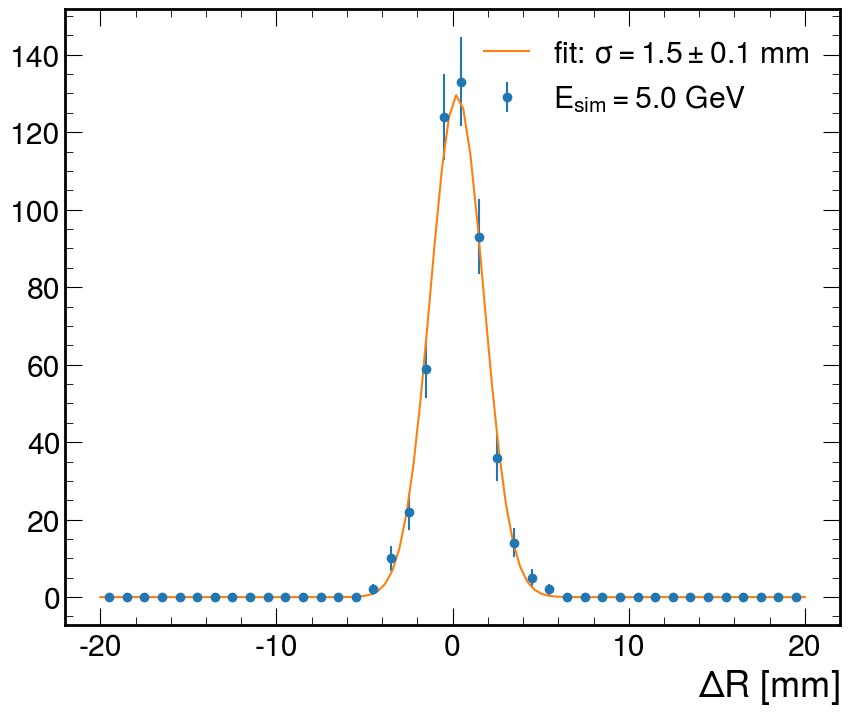

/home/sebouh/.local/lib/python3.8/site-packages/awkward/_connect/_numpy.py:209: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(


chi2=7.9, ndof=3, pval=0.0484


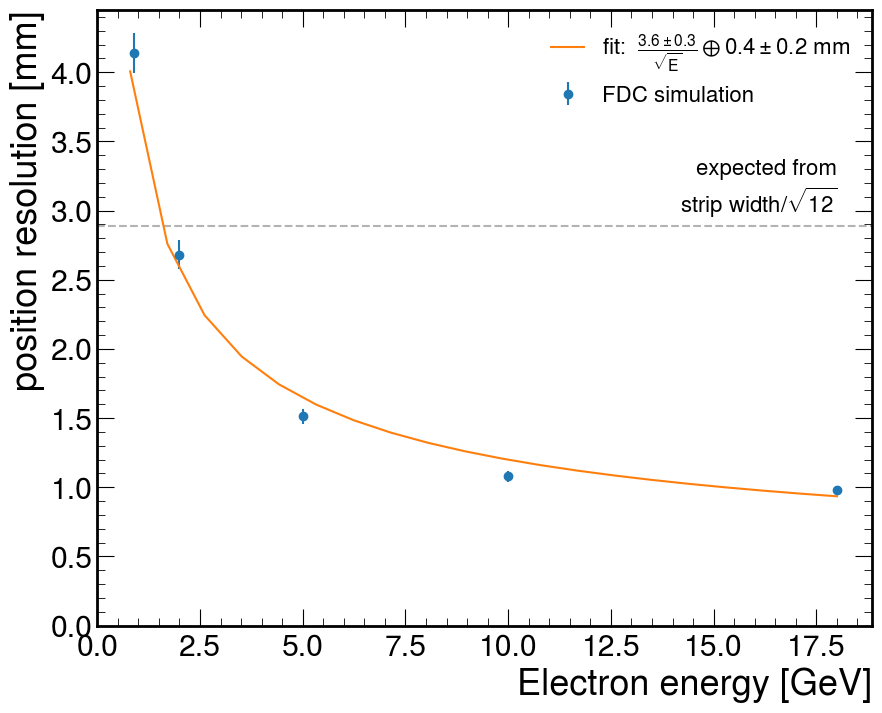

In [128]:


energies=np.array([0.9, 2, 5, 10, 18])

for w0 in 4,:
    resolutions={a:[] for a in 'xyr'}
    dresolutions={a:[] for a in 'xyr'}
    for Ebeam in energies:
        key=Ebeam,178
        dxs, dys,drs=[],[],[]
        for event in range(len(arrays[key])):
            E=arrays[key]['BackwardsEcalInsertHitsReco.energy'][event]

            #filter the hits that are on x and y measuring layers
            #print(arrays[key]['BackwardsEcalInsertHitsReco.dimension.x'][event])
            isY=(arrays[key]['BackwardsEcalInsertHitsReco.dimension.x'][event]>20) & (E>0)
            isX=(arrays[key]['BackwardsEcalInsertHitsReco.dimension.y'][event]>20) & (E>0)

            #must have at least one hit in a horizontal layer and at least one in a vertical layer
            if not sum(E[isX])*sum(E[isY]):
                continue

            x=arrays[key]['BackwardsEcalInsertHitsReco.position.x'][event]
            y=arrays[key]['BackwardsEcalInsertHitsReco.position.y'][event]
            z=arrays[key]['BackwardsEcalInsertHitsReco.position.z'][event]
            #weights for the x and y measuring layers
            if w0>0:
                wX=(w0+np.log(E/np.sum(E[isX])))[isX]
                wX=wX*(wX>0)
                wY=(w0+np.log(E/np.sum(E[isY])))[isY]
                wY=wY*(wY>0)
            else:
                wX=E[isX]
                wY=E[isY]
            if not sum(wX)*sum(wY):
                continue

            xrecon=np.sum(x[isX]*wX)/sum(wX)
            yrecon=np.sum(y[isY]*wY)/sum(wY)
            zrecon_x=np.sum(z[isX]*wX)/sum(wX)
            zrecon_y=np.sum(z[isY]*wY)/sum(wY)

            MC_px=arrays[key]["MCParticles.momentum.x"][event,2]
            MC_py=arrays[key]["MCParticles.momentum.y"][event,2]
            MC_pz=arrays[key]["MCParticles.momentum.z"][event,2]

            xtruth=MC_px/MC_pz*zrecon_x
            ytruth=MC_py/MC_pz*zrecon_y

            dxs.append(xrecon-xtruth)
            dys.append(yrecon-ytruth)
            
            drs.append(np.hypot(xrecon,yrecon)-np.hypot(xtruth,ytruth))
        for k,a in ('r',drs),:
            show=Ebeam==5
            fnc=gauss
            r=(-20,20)

            h,x=np.histogram(a, bins=40 if Ebeam>=2 else 30, range=r)
            bc=(x[1:]+x[:-1])/2
            if show : plt.errorbar(bc, h, np.sqrt(h), marker='o', ls='', label=f'$E_{{\\rm sim}}={Ebeam}$ GeV')
            p0=[10,0, np.std(dxs)]
            slc=h>0
            coeff, var_matrix = curve_fit(fnc, bc[slc], h[slc], p0=p0,
                                     sigma=np.sqrt(h[slc]))
            x=np.linspace(*r, 100)
            if show : plt.plot(x, fnc(x,*coeff), label=f"fit: $\\sigma={coeff[2]:.1f}\\pm{np.sqrt(var_matrix[2][2]):.1f}$ mm")
            if show : plt.xlabel("$\\Delta R$ [mm]")
            resolutions[k].append(coeff[2])
            dresolutions[k].append(np.sqrt(var_matrix[2][2]))
            if show : 
                plt.legend()
                plt.savefig("images/position_resolution_slice.pdf")
                plt.show()
        
#         h,x=np.histogram(dys, bins=30, range=(-20,20))
#         bc=(x[1:]+x[:-1])/2
#         plt.errorbar(bc, h, np.sqrt(h), marker='o', ls='', label=f'$E_{{\\rm sim}}={Ebeam}$ GeV')
#         p0=[10,0, np.std(dxs)]
#         slc=h>0
#         coeff, var_matrix = curve_fit(fnc, bc[slc], h[slc], p0=p0,
#                                  sigma=np.sqrt(h[slc]))
#         x=np.linspace(*r, 100)
#         plt.plot(x, fnc(x,*coeff), label=f"fit")
#         plt.xlabel("$\\Delta y$ [mm]")
#         yres.append(coeff[2])
#         dyres.append(np.sqrt(var_matrix[2][2]))
#         plt.legend()
#         plt.show()
        
        
#         xres.append(np.std(dxs))
#         yres.append(np.std(dys))
#         dxres.append(np.std(dxs)/np.sqrt(len(dxs)))
#         dyres.append(np.std(dxs)/np.sqrt(len(dys)))
#     xres=np.array(xres)
#     yres=np.array(yres)
#     dxres=np.array(dxres)
#     dyres=np.array(dyres)
    resolutions = {k:np.array(resolutions[k]) for k in resolutions}
    dresolutions = {k:np.array(dresolutions[k]) for k in dresolutions}
    plt.errorbar(energies, resolutions['r'], dresolutions['r'], ls='', marker='o', label='FDC simulation')
    #plt.errorbar(energies+.1, yres, dyres, ls='', marker='s', label='y')
    plt.axhline(10/np.sqrt(12), ls='--', color='0.7')
    plt.text(18,10/np.sqrt(12)+.1, "expected from\nstrip width/$\\sqrt{12}$", ha='right', fontsize=16)
    
    p0=[1, 1]
    fnc=lambda x, a,b: np.hypot(a/np.sqrt(x), b)
    coeff, var_matrix = curve_fit(fnc, energies, resolutions['r'], p0=p0,
                                 sigma=dresolutions['r'])
    chi2=sum((fnc(energies,*coeff)-yres)**2/dyres**2)
    ndof = len(energies)-len(coeff)
    from scipy.stats import chi2 as c2
    print(f"chi2={chi2:.1f}, ndof={ndof}, pval={c2.sf(chi2,ndof):.3}")

    label=f"fit:  $\\frac{{{coeff[0]:.1f}\pm {np.sqrt(var_matrix[0][0]):.1f}}}{{\\sqrt{{E}}}}" \
            + f" \\oplus {coeff[1]:.1f}\pm {np.sqrt(var_matrix[1][1]):.1f}$ mm" 

    x=np.linspace(0.8, 18, 20)
    plt.plot(x, fnc(x, *coeff), label=label)
    
    
plt.xlim(0)
plt.ylim(0)
plt.xlabel("Electron energy [GeV]")
plt.ylabel("position resolution [mm]")
#compare to other experiments
#plt.errorbar([5], [1.68], [0.07],label="BPC", marker='s', fillstyle='none')
plt.legend(fontsize=16)
plt.savefig("images/position_resolution.pdf")
plt.show()
    #print(event, yrecon, xrecon)
#plt.hist(dxs)
#plt.show()
#plt.hist(dys)
#plt.show()

In [ ]:
0.02*np.pi/180*-320